In [1]:
"""
Random Forest model

Oversampling vs. SMOTE oversampling

Refine features to include

"""

'\nSecond Random Forest model with more features and balance the classes by oversampling\n\n'

In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle

In [2]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

In [5]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

In [6]:
# the df with features and target

with open('data_model_training.pickle', 'rb') as read_file:
    model_data = pickle.load(read_file)
    
model_data.head()

,company_name,FULL_NAME,period_end_date,submission_number,central_index_key,ein,sic,fiscal_year_end,fiscal_year,form,...,current_ratio,leverage,return_on_equity,return_on_assets,ratio_1,ratio_2,ratio_3,ratio_4,EarningsPerShareBasic,EarningsPerShareDiluted
0,1 800 FLOWERS COM INC,NaN,2014-06-30,0001437749-17-015969,1084869,113117311,5990,630,2017,10-K,...,1.235657,1.460306,NaN,NaN,0.684788,1.179782,3.285030,4.099066,0.24,0.23
1,1 800 FLOWERS COM INC,NaN,2015-06-30,0001437749-18-017027,1084869,113117311,5990,630,2018,10-K,...,1.254743,2.384626,NaN,NaN,0.419353,0.980128,1.733067,1.792763,0.31,0.30
2,1 800 FLOWERS COM INC,NaN,2016-06-30,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,1.378931,2.073248,NaN,NaN,0.482335,1.028864,1.931751,2.104657,0.57,0.55
3,1 800 FLOWERS COM INC,NaN,2017-06-30,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,2.056337,1.957454,0.156042,0.079717,0.510868,0.941736,2.044436,2.043737,0.68,0.65
4,1 800 FLOWERS COM INC,NaN,2018-06-30,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,2.187686,1.812899,0.129535,0.071452,0.551603,0.856603,2.230166,2.031857,0.63,0.61


In [7]:
model_data.shape

(19919, 52)

In [9]:
#model_data.columns

In [10]:
# fill infinity values with NaN

model_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [11]:
## split into 3 parts to handle missing

model_ready_1 = model_data[['company_name', 'FULL_NAME', 'period_end_date', 'submission_number',
       'central_index_key', 'ein', 'sic', 'fiscal_year_end', 'fiscal_year',
       'form', 'date_filed', 'Industry', 'div_code', 'Division',
       'bankruptcy_date', 'days', 'target']]

In [15]:
## RF will not accept NaNs

## change all NaN to zero where large values

model_ready_2 = model_data[['Assets_MM', 'AssetsCurrent_MM',
       'Libilities_MM', 'LibilitiesCurrent_MM', 'NetIncomeLoss_MM',
       'StockholdersEquity_MM', 'OperatingIncomeLoss_MM', 'Revenues_MM',
       'CashAndCashEquivalentsAtCarryingValue_MM', 'CommonStockValue_MM',
       'Goodwill_MM', 'GrossProfit_MM', 'InterestExpense_MM', 'Revenue_any_MM',
       'SalesRevenueGoodsNet_MM', 'SalesRevenueNet_MM',
       'NetCashProvidedByUsedInFinancingActivities_MM',
       'NetCashProvidedByUsedInInvestingActivities_MM',
       'NetCashProvidedByUsedInOperatingActivities_MM',
       'LongTermDebtMaturitiesRepaymentsOfPrincipalInNextTwelveMonths_MM',
       'LongTermDebtNoncurrent_MM', 'LongTermDebt_MM',
       'RepaymentsOfLongTermDebt_MM']].fillna(-999999)


In [16]:
min(model_ready_2.OperatingIncomeLoss_MM)

-999999.0

In [17]:
model_ready_2.head()

,Assets_MM,AssetsCurrent_MM,Libilities_MM,LibilitiesCurrent_MM,NetIncomeLoss_MM,StockholdersEquity_MM,OperatingIncomeLoss_MM,Revenues_MM,CashAndCashEquivalentsAtCarryingValue_MM,CommonStockValue_MM,...,Revenue_any_MM,SalesRevenueGoodsNet_MM,SalesRevenueNet_MM,NetCashProvidedByUsedInFinancingActivities_MM,NetCashProvidedByUsedInInvestingActivities_MM,NetCashProvidedByUsedInOperatingActivities_MM,LongTermDebtMaturitiesRepaymentsOfPrincipalInNextTwelveMonths_MM,LongTermDebtNoncurrent_MM,LongTermDebt_MM,RepaymentsOfLongTermDebt_MM
0,267.569,91.818,81.451,74.307,-999999.000,183.228,23.706,-999999.000,5.203,-999999.0,...,756.345,-999999.0,756.345,-6.002,-31.488,42.539,-999999.0,-999999.0,-999999.0,-999999.0
1,497.073,155.095,286.817,123.607,-999999.000,208.449,37.617,-999999.000,27.940,-999999.0,...,1121.506,-999999.0,1121.506,60.607,-163.603,125.733,-999999.0,-999999.0,-999999.0,-999999.0
2,502.941,166.659,260.355,120.861,-999999.000,242.586,43.282,1173.024,27.826,-999999.0,...,1173.024,-999999.0,1173.024,-23.849,-33.938,57.673,-999999.0,-999999.0,-999999.0,-999999.0
3,552.470,257.402,270.231,125.175,44.041,282.239,46.359,1193.625,149.732,-999999.0,...,1193.625,-999999.0,1193.625,-17.406,78.302,61.010,-999999.0,-999999.0,-999999.0,-999999.0
4,570.889,273.021,255.985,124.799,40.791,314.904,41.048,1151.921,147.240,-999999.0,...,1151.921,-999999.0,-999999.000,-19.027,-41.806,58.341,-999999.0,-999999.0,-999999.0,-999999.0


In [18]:
## change to large extreme negative where ratios

model_ready_3 = model_data[['debt_ratio', 'debt_equity_ratio',
       'current_ratio', 'leverage', 'return_on_equity', 'return_on_assets',
       'ratio_1', 'ratio_2', 'ratio_3', 'ratio_4', 'EarningsPerShareBasic',
       'EarningsPerShareDiluted']].fillna(-999999)


In [19]:
model_ready = pd.concat([model_ready_1, model_ready_2, model_ready_3], axis=1)

In [20]:
model_ready.shape

(19919, 52)

In [21]:
model_ready.company_name.nunique()

5373

In [22]:
# one hot encoding for the industry division

div_code = model_ready[['Division']]

one = OneHotEncoder(sparse=False)
one.fit(div_code)
cats = one.transform(div_code)

columns = one.get_feature_names(['Division'])
div_code_df = pd.DataFrame(cats, columns=columns, index=div_code.index)

div_code_df

,"Division_Agriculture, Forestry and Fishing",Division_Construction,"Division_Finance, Insurance and Real Estate",Division_Manufacturing,Division_Mining,Division_Retail Trade,Division_Services,"Division_Transportation, Communications, Electric, Gas and Sanitary service",Division_Wholesale Trade
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
19914,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19915,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19916,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19917,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [31]:
rfm_ready = pd.concat([model_ready, div_code_df], axis=1)
rfm_ready.shape

(19919, 61)

In [32]:
## deviation features

def add_deviation_feature(X, feature, category):
    
    # temp groupby object
    category_gb = X.groupby(category)[feature]
    
    # create columns of category means and standard deviations
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    
    # compute stds from category mean for each feature value,
    # add to X as new feature
    deviation_feature = (X[feature] - category_mean) / category_std 
    X[feature + '_Dev_' + category] = deviation_feature  


In [35]:
rfm_w_dev = rfm_ready.copy()

In [36]:

add_deviation_feature(rfm_w_dev, 'debt_ratio', 'Division')
add_deviation_feature(rfm_w_dev, 'debt_equity_ratio', 'Division')
add_deviation_feature(rfm_w_dev, 'current_ratio', 'Division')
add_deviation_feature(rfm_w_dev, 'leverage', 'Division')
add_deviation_feature(rfm_w_dev, 'return_on_equity', 'Division')
add_deviation_feature(rfm_w_dev, 'return_on_assets', 'Division')
add_deviation_feature(rfm_w_dev, 'ratio_1', 'Division')
add_deviation_feature(rfm_w_dev, 'ratio_2', 'Division')
add_deviation_feature(rfm_w_dev, 'ratio_3', 'Division')
add_deviation_feature(rfm_w_dev, 'ratio_4', 'Division')
add_deviation_feature(rfm_w_dev, 'EarningsPerShareBasic', 'Division')
add_deviation_feature(rfm_w_dev, 'EarningsPerShareDiluted', 'Division')


In [37]:
rfm_w_dev.head()

,company_name,FULL_NAME,period_end_date,submission_number,central_index_key,ein,sic,fiscal_year_end,fiscal_year,form,...,current_ratio_Dev_Division,leverage_Dev_Division,return_on_equity_Dev_Division,return_on_assets_Dev_Division,ratio_1_Dev_Division,ratio_2_Dev_Division,ratio_3_Dev_Division,ratio_4_Dev_Division,EarningsPerShareBasic_Dev_Division,EarningsPerShareDiluted_Dev_Division
0,1 800 FLOWERS COM INC,NaN,2014-06-30,0001437749-17-015969,1084869,113117311,5990,630,2017,10-K,...,0.108022,0.181646,-2.880696,-3.432926,0.181656,0.741941,0.186811,1.310837,0.443194,0.441760
1,1 800 FLOWERS COM INC,NaN,2015-06-30,0001437749-18-017027,1084869,113117311,5990,630,2018,10-K,...,0.108022,0.181652,-2.880696,-3.432926,0.181654,0.741941,0.186802,1.310833,0.443194,0.441760
2,1 800 FLOWERS COM INC,NaN,2016-06-30,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,0.108024,0.181650,-2.880696,-3.432926,0.181655,0.741941,0.186804,1.310833,0.443195,0.441761
3,1 800 FLOWERS COM INC,NaN,2017-06-30,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,0.108030,0.181649,0.346829,0.291038,0.181655,0.741941,0.186804,1.310833,0.443195,0.441761
4,1 800 FLOWERS COM INC,NaN,2018-06-30,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,0.108031,0.181648,0.346829,0.291038,0.181655,0.741940,0.186805,1.310833,0.443195,0.441761


In [107]:
rfm_w_dev.columns

Index(['company_name', 'FULL_NAME', 'period_end_date', 'submission_number',
       'central_index_key', 'ein', 'sic', 'fiscal_year_end', 'fiscal_year',
       'form', 'date_filed', 'Industry', 'div_code', 'Division',
       'bankruptcy_date', 'days', 'target', 'Assets_MM', 'AssetsCurrent_MM',
       'Libilities_MM', 'LibilitiesCurrent_MM', 'NetIncomeLoss_MM',
       'StockholdersEquity_MM', 'OperatingIncomeLoss_MM', 'Revenues_MM',
       'CashAndCashEquivalentsAtCarryingValue_MM', 'CommonStockValue_MM',
       'Goodwill_MM', 'GrossProfit_MM', 'InterestExpense_MM', 'Revenue_any_MM',
       'SalesRevenueGoodsNet_MM', 'SalesRevenueNet_MM',
       'NetCashProvidedByUsedInFinancingActivities_MM',
       'NetCashProvidedByUsedInInvestingActivities_MM',
       'NetCashProvidedByUsedInOperatingActivities_MM',
       'LongTermDebtMaturitiesRepaymentsOfPrincipalInNextTwelveMonths_MM',
       'LongTermDebtNoncurrent_MM', 'LongTermDebt_MM',
       'RepaymentsOfLongTermDebt_MM', 'debt_ratio', 'debt

In [121]:
X_features = rfm_w_dev[['debt_ratio', 'debt_equity_ratio',
       'current_ratio', 'leverage', 'return_on_equity', 'return_on_assets',
                 'EarningsPerShareDiluted', 'ratio_2',
                        
                                                
                        'Assets_MM', 'AssetsCurrent_MM',
       'Libilities_MM', 'LibilitiesCurrent_MM', 
                        
                           'NetIncomeLoss_MM',
       'StockholdersEquity_MM', 'OperatingIncomeLoss_MM', 
'Division_Agriculture, Forestry and Fishing',
       'Division_Construction',
                    
                  'Division_Finance, Insurance and Real Estate', 
                 'Division_Manufacturing', 'Division_Mining', 'Division_Retail Trade', 
                 'Division_Services', 'Division_Wholesale Trade',
                 'Division_Transportation, Communications, Electric, Gas and Sanitary service', 
                       
                       'debt_ratio_Dev_Division',
       'debt_equity_ratio_Dev_Division', 'current_ratio_Dev_Division',
       'leverage_Dev_Division', 'return_on_equity_Dev_Division',
       'return_on_assets_Dev_Division', 'ratio_2_Dev_Division',
        
       'EarningsPerShareDiluted_Dev_Division']]

y = rfm_w_dev['target']

In [122]:
# arrays for KFold
X, y = np.array(X_features), np.array(y)

kf = KFold(n_splits=5, shuffle=True, random_state = 47)
cv_rfm_recall = [] #collect the recall scores
#cv_rfm_matrix = []

for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #balance the training set classes
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

    
    #Random Forest
    randomforest = RandomForestClassifier(n_estimators=100)

    randomforest.fit(X_resampled, y_resampled)
      
    y_pred = randomforest.predict(X_val)
    
    cv_rfm_recall.append(round(recall_score(y_val, y_pred), 4))
      
    rf_confusion = confusion_matrix(y_val, y_pred)
    
    print('Matrix:' , rf_confusion)

print('RFM recall scores: ', cv_rfm_recall, '\n')

print(f'Mean CV recall: {np.mean(cv_rfm_recall):.3f} +- {np.std(cv_rfm_recall):.3f}', '\n')



Matrix: [[3931   13]
 [  30   10]]
Matrix: [[3919   21]
 [  35    9]]
Matrix: [[3914   12]
 [  50    8]]
Matrix: [[3917   13]
 [  41   13]]
Matrix: [[3928   13]
 [  37    5]]
RFM recall scores:  [0.25, 0.2045, 0.1379, 0.2407, 0.119] 

Mean CV recall: 0.190 +- 0.053 



In [ ]:
## above went to 0.20 when removed agriculture as well as construction industry features
## removed ratio #3 when to 0.19
## removed ratio_3 deviation, ratio 4, ratio 4 dev, and earnings per share basic - went to 0.178
## remove ratio 1 that is opposite ratio of leverage - went to 0.179
## tried without any MM -- 0.14
## without industry division - 0.134
## without ratio 2 - 0.11
## add divisions back -- 0.12
## add back ratio 2 -- 0.14
## add back the MM ecept A and L -- 0.18
## add back the A and L -- 0.18
## add back last 2 indust -- 0.19

In [ ]:
## try SMOTE oversampling


In [123]:
# arrays for KFold
X, y = np.array(X), np.array(y)

kf = KFold(n_splits=5, shuffle=True, random_state = 47)
cv_rfm_recall = [] #collect the recall scores
#cv_rfm_matrix = []

for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #balance the training set classes
    X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train, y_train)

    #Random Forest
    randomforest = RandomForestClassifier(n_estimators=100)

    randomforest.fit(X_smoted, y_smoted)
      
    y_pred = randomforest.predict(X_val)
    
    cv_rfm_recall.append(round(recall_score(y_val, y_pred), 4))
      
    rf_confusion = confusion_matrix(y_val, y_pred)
    
    print('Matrix:' , rf_confusion)

print('RFM recall scores: ', cv_rfm_recall, '\n')

print(f'Mean CV recall: {np.mean(cv_rfm_recall):.3f} +- {np.std(cv_rfm_recall):.3f}', '\n')





Matrix: [[3906   38]
 [  28   12]]
Matrix: [[3889   51]
 [  26   18]]
Matrix: [[3898   28]
 [  42   16]]
Matrix: [[3892   38]
 [  32   22]]
Matrix: [[3911   30]
 [  30   12]]
RFM recall scores:  [0.3, 0.4091, 0.2759, 0.4074, 0.2857] 

Mean CV recall: 0.336 +- 0.060 



In [ ]:
## boo, went down with addition of deviation features, was .35 went to .296
## next try remove some less splitting important MM  -- wento to 0.308
## removed agriculture and construction, when to 0.306
## removed ratio # 3  - went to 0.316
## removed ratio_3 deviation, ratio 4, ratio 4 dev, and earnings per share basic - went to 0.311
## removed ratio 1 that was opposite of leverage
## removed MM values - went to 0.323 -- false positives went up around 60 each kfold
## without industry division -- went to 0.329  false positives 50-60
## without ratio 2 -- 0.282   false postivives up to 71
## added divsions back weent to 0.27
## add back ratio 2 --  0.31 still a 70 FP
## add back MM except A and L -- 0.33 -- FP down to most 54
## add back the A and L -- 0.31 --= FP at most 46
## add back last 2 industries 0.336 - FP at most 51

In [124]:
len(randomforest.feature_importances_)

32

In [125]:
len(X_features.columns)

32

<BarContainer object of 32 artists>

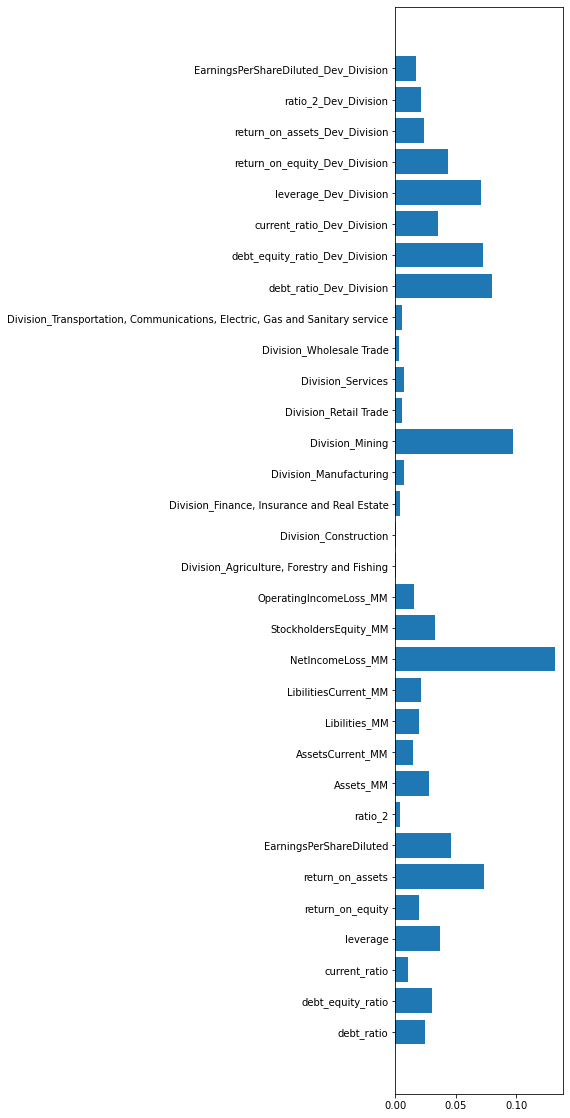

In [126]:
feature_names = X_features.columns

## last k-fold
#plt.rcParams["figure.figsize"] = (3,20)
plt.barh(feature_names, randomforest.feature_importances_)

In [ ]:
#Precision-Recall curves summarize the trade-off between the true positive rate and 
#the positive predictive value for a predictive model using different probability thresholds.

#Precision-Recall curves appropriate for imbalanced classes


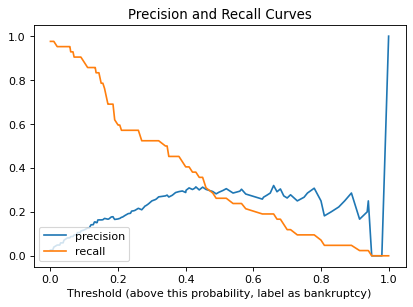

In [51]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, randomforest.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:],label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as bankruptcy)');
plt.title('Precision and Recall Curves');

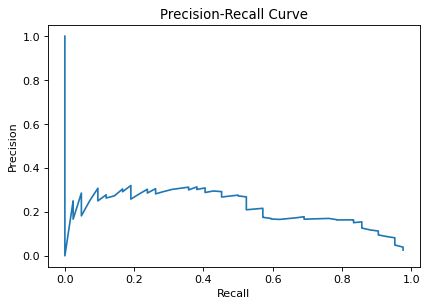

In [52]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

ROC AUC score =  0.954277981174708


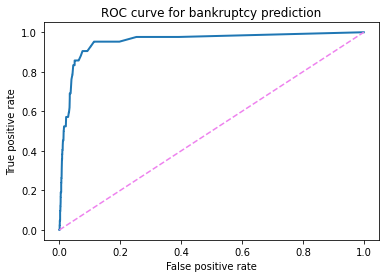

In [53]:
# ROC is appropriate for balanced classes, this is the code block

fpr, tpr, thresholds = roc_curve(y_val, randomforest.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for bankruptcy prediction');
print("ROC AUC score = ", roc_auc_score(y_val, randomforest.predict_proba(X_val)[:,1]))

In [54]:
## confusion matrix
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    prob_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(prob_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No', 'Yes'],
           yticklabels=['No', 'Yes']);
    plt.xlabel('Predicted Bankruptcy')
    plt.ylabel('Actual Bankruptcy')

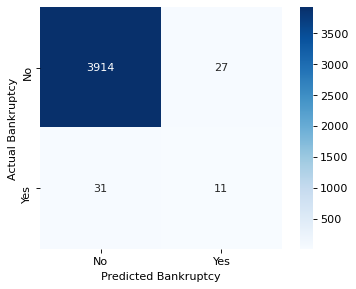

In [55]:
# last validation set in K-fold CV
make_confusion_matrix(randomforest)